In [1]:
import os
import sys
from importlib import reload
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.io as sio

from icecream import ic, colorize as ic_colorize, argumentToString

sns.set_theme(rc={"legend.facecolor": "w"})
mpl.rcParams["pdf.fonttype"] = 42

os.environ["PYDEVD_DISABLE_FILE_VALIDATION"] = "1"

# Register a function to summarize numpy array
@argumentToString.register
def argumentToString_ndarray(obj: np.ndarray):
  return (
    f"ndarray, shape={obj.shape}, dtype={obj.dtype}, "
    f"min={obj.min()}, max={obj.max()}"
  )


ic.configureOutput(prefix="⚡ ")
ic.configureOutput(outputFunction=lambda s: print(ic_colorize(s)))

np.set_printoptions(threshold=10, precision=4)

%load_ext autoreload
%autoreload 2

In [8]:
from admice.dataload import session_from_mouse_from_matfile, Session

In [37]:
dataRoot = os.path.expanduser("~/data/tedho_ad_mice/")

def load_mat(fname:str) -> dict:
  file = os.path.join(dataRoot, fname)
  return sio.loadmat(
    file, struct_as_record=True, squeeze_me=True, chars_as_strings=True
  )

def load_mice_from_mat(fname:str, key:str, group:str) -> list[Session]:
  ld = load_mat(fname) 
  mice = ld[key][1:] # first entry is string description
  sessions = [session_from_mouse_from_matfile(mouse, group) for mouse in mice]
  return sessions

sess_ctrl = load_mice_from_mat("workspace_28-Jun-2024_control_mice_2p_data_for_dan.v7.mat", "controlmice", "control")
sess_young = load_mice_from_mat("workspace_28-Jun-2024_young3xtg_mice_2p_data_for_dan.v7.mat", "young3xtgmice", "young_3xtg")
sess_old = load_mice_from_mat("workspace_28-Jun-2024_old3xtg_mice_2p_data_for_dan.v7.mat", "old3xtgmice", "old_3xtg")

In [52]:
from admice.eventlda import pipeline_lda_tone_sliding, multimouse_pipeline_lda_tone_sliding

window_width = 22
window_buffer = 4

res_ctrl = multimouse_pipeline_lda_tone_sliding(sess_ctrl, window_width=window_width, window_buffer=window_buffer)
res_young = multimouse_pipeline_lda_tone_sliding(sess_young, window_width=window_width, window_buffer=window_buffer)
res_old = multimouse_pipeline_lda_tone_sliding(sess_old, window_width=window_width, window_buffer=window_buffer)

old_3xtg 0 / 6: id 28
old_3xtg 1 / 6: id 29
old_3xtg 2 / 6: id 30
old_3xtg 3 / 6: id 31
old_3xtg 4 / 6: id 32
old_3xtg 5 / 6: id 52


In [80]:
import pandas as pd
def res_to_df(res) -> pd.DataFrame:
  S, T = res.accuracy_st.shape
  total_time = float(T-1) / 30. 
  time_sec = np.linspace(0, total_time, T)
  time_rel_event = time_sec 
  time_rel_event = time_rel_event - time_rel_event[res.event_ind]

  data = {
    'group': np.repeat(res.group, S*T),
    'mouse_id': np.repeat(res.mouse_ids, T),
    'time_rel_tone': np.tile(time_rel_event, S),
    'accuracy': res.accuracy_st.flatten()
  }
  df = pd.DataFrame(data)
  return df

In [81]:
df_ctrl = res_to_df(res_ctrl)
df_young = res_to_df(res_young)
df_old = res_to_df(res_old)

In [82]:
df_all = pd.concat([df_ctrl, df_young, df_old], ignore_index=True)

df_all

,group,mouse_id,time_rel_tone,accuracy
0,control,27,-4.966667,NaN
1,control,27,-4.933333,NaN
2,control,27,-4.900000,NaN
3,control,27,-4.866667,NaN
4,control,27,-4.833333,NaN
...,...,...,...,...
5343,old_3xtg,52,3.766667,NaN
5344,old_3xtg,52,3.800000,NaN
5345,old_3xtg,52,3.833333,NaN
5346,old_3xtg,52,3.866667,NaN


<Axes: xlabel='time_rel_tone', ylabel='accuracy'>

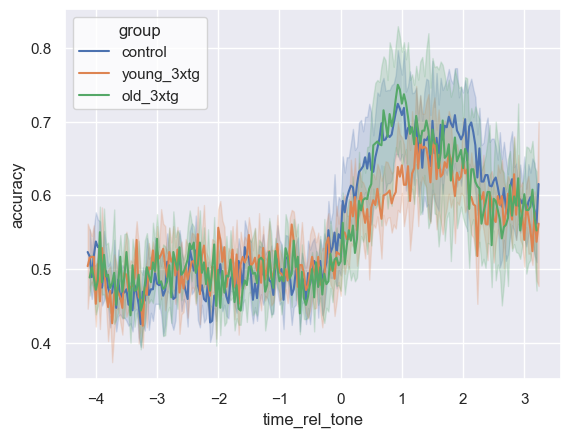

In [83]:
sns.lineplot(x="time_rel_tone", y="accuracy", hue="group", data=df_all)

In [61]:
df_ctrl = res_ctrl.to_df()

AttributeError: 'EventLDAResults' object has no attribute 'to_df'

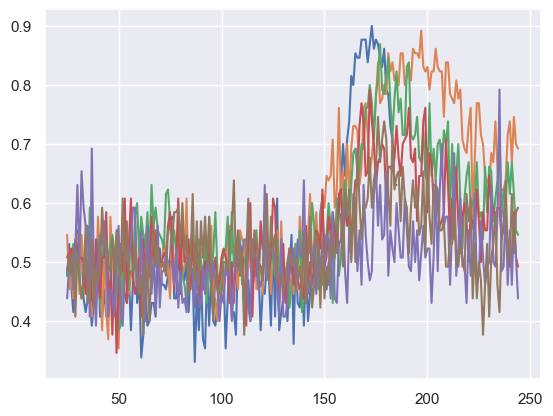

In [53]:
plt.plot(res_old.accuracy_st.T)

In [48]:
from dataclasses import dataclass

@dataclass
class EventLDAResults:
  event: str
  group: str
  mouse_ids: np.ndarray # S
  event_ind: int 
  accuracy_st: np.ndarray # sessions x time

  window_width: int
  window_buffer: int

  fps: float = 30

  @property
  def n_time(self) -> int:
    return self.data_nrt.shape[2]

  @property
  def dt_sec(self) -> float:
    return  1. / float(self.fps)

  @property
  def time_sec(self) -> np.ndarray:
    T = (self.n_time-1) * self.dt_sec
    return np.linspace(0, T, self.n_time)

def align_and_stack_vectors(data: list[np.ndarray], align_idx: list[int]) -> tuple[np.ndarray, int]:
  # Determine the maximum length of the arrays after alignment
  max_left = max(align_idx)
  max_right = max(len(arr) - idx for arr, idx in zip(data, align_idx))

  # The width of the result matrix
  total_length = max_left + max_right

  # Column index where the align_idx values will end up
  column_index = max_left

  # Initialize the matrix with NaNs
  result = np.full((len(data), total_length), np.nan)

  # Fill the matrix with aligned arrays
  for i, (arr, idx) in enumerate(zip(data, align_idx)):
    start_idx = max_left - idx
    result[i, start_idx:start_idx + len(arr)] = arr

  return result, column_index

def multimouse_pipeline_lda_tone_sliding(mice: list[Session], window_width: int, window_buffer: int, group: str | None = None) -> EventLDAResults:
  if group is None:
    group = mice[0].group

  acc = []
  for mouse in mice:
    ic(group, mouse.mouse_id)
    acc.append(pipeline_lda_tone_sliding(mouse, window_width=window_width, window_buffer=window_buffer))

  mouse_ids = [mouse.mouse_id for mouse in mice]
  event_inds = [mouse.tone_ind for mouse in mice]
  accuracy_st, event_ind = align_and_stack_vectors(acc, event_inds)
  res = EventLDAResults(event="tone", group=group, mouse_ids=mouse_ids, event_ind=event_ind, accuracy_st=accuracy_st, window_width=window_width, window_buffer=window_buffer)
  return res

In [44]:
res_ctrl = multimouse_pipeline_lda_tone_sliding(sess_ctrl, window_width=window_width, window_buffer=window_buffer)
ic(res_ctrl);

⚡ res_ctrl: EventLDAResults(event='tone',
                            group='control',
                            mouse_ids=[27, 15, 17, 25, 33, 34, 35],
                            event_ind=149,
                            accuracy_st=array([[nan, nan, nan, ..., nan, nan, nan],
                   [nan, nan, nan, ..., nan, nan, nan],
                   [nan, nan, nan, ..., nan, nan, nan],
                   ...,
                   [nan, nan, nan, ..., nan, nan, nan],
                   [nan, nan, nan, ..., nan, nan, nan],
                   [nan, nan, nan, ..., nan, nan, nan]]),
                            window_width=22,
                            window_buffer=4)


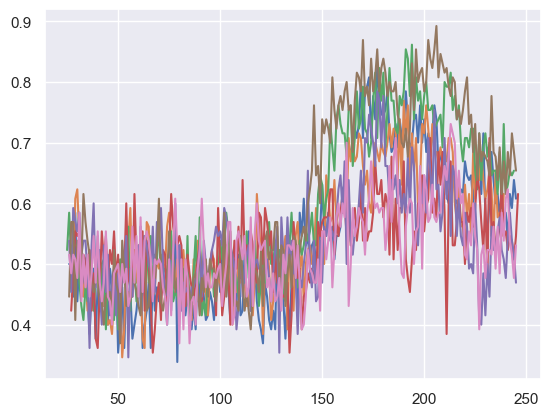

In [46]:
plt.plot(res_ctrl.accuracy_st.T)

In [ ]:
from dataclasses import dataclass

@dataclass
class EventLDAResults:
  event: str
  group: str
  mouse_ids: np.ndarray # S
  time_sec: np.ndarray # T
  event_ind: int 
  accuracy_st: np.ndarray # sessions x time

  window_width: int
  window_buffer: int

ids = [mouse.mouse_id for mouse in sess_ctrl]
accuracy_st = np.
res_ctrl = EventLDAResults(event="tone", group="control", mouse_ids = ids, time_sec=sess_ctrl[0].time_sec, event_ind=sess_ctrl[0].tone_ind, accuracy_st = )

In [ ]:
acc_young = []
for mouse in sess_young:
  ic("Young", mouse.mouse_id)
  acc_young.append(pipeline_lda_tone_sliding(mouse, window_width=window_width, window_buffer=window_buffer))

In [ ]:
acc_old = []
for mouse in sess_ctrl:
  ic("Old", mouse.mouse_id)
  acc_ctrl.append(pipeline_lda_tone_sliding(mouse, window_width=window_width, window_buffer=window_buffer))

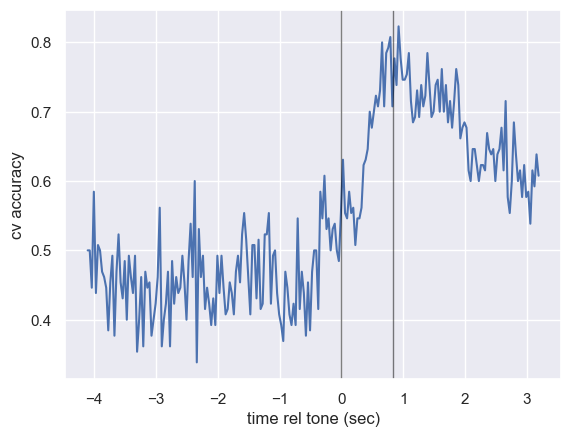

In [25]:
window_width_sec = window_width * sess.dt_sec
t_offset = -sess.tone_time
plt.plot(sess.time_sec + t_offset, accuracy)

plt.axvline(sess.tone_time + t_offset, c=[0, 0, 0, 0.5], linewidth=1, label="tone")
plt.axvline(sess.puff_time + t_offset, c=[0, 0, 0, 0.5], linewidth=1, label="puff")
plt.xlabel("time rel tone (sec)")
plt.ylabel("cv accuracy");

## Try on multiple control mice

In [1]:
from admice import dataload

ModuleNotFoundError: No module named 'admice'

In [9]:
import scipy.io as sio
from tedho_ad_mice.dataload import session_from_mouse_from_matfile

control_fname = os.path.join(
  dataRoot, "workspace_28-Jun-2024_control_mice_2p_data_for_dan.v7.mat"
)

ld = sio.loadmat(
  control_fname, struct_as_record=True, squeeze_me=True, chars_as_strings=True
)

mice = [session_from_mouse_from_matfile(mouse) for mouse in ld["controlmice"]]

ModuleNotFoundError: No module named 'tedho_ad_mice'

In [ ]:
# Plot the cross-validated accuracy vs. time
plt.figure(figsize=(10, 6))
plt.plot(range(T), accuracies, marker="o")
plt.xlabel("Timepoint")
plt.ylabel("Cross-Validated Accuracy")
plt.title("LDA Cross-Validated Accuracy vs. Time")
plt.grid(True)
plt.show()